In [1]:
# 6. Grid based Multiple Object Detection

In [4]:
!pip list | grep tensorflow

tensorflow                               2.11.0
tensorflow-estimator                     2.11.0
tensorflow-io-gcs-filesystem             0.37.1


In [1]:
# Import libraries

import numpy as np
import tensorflow as tf
import cv2 as cv
import random
import matplotlib.pyplot as plt

2025-04-08 04:32:32.411566: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-08 04:32:32.414193: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-08 04:32:32.421108: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744054352.431998   35636 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744054352.435215   35636 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744054352.444616   35636 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
# Generate training images and labels
N=4000
H,W=256,256
GHN,GWN=8,8
GH,GW=int(H/GHN),int(W/GWN)
Mmax=3 # maximum number of objects

train_img=np.zeros([N,H,W,3],dtype=np.uint8)
train_img.fill(255)
train_label_conf=np.zeros([N,GHN,GWN,1],dtype=np.float32)
train_label_coord=np.zeros([N,GHN,GWN,2],dtype=np.float32)
train_label_size=np.zeros([N,GHN,GWN,2],dtype=np.float32)
train_label_class=np.zeros([N,GHN,GWN,1],dtype=np.float32)

In [3]:
for n in range(N):
  M=random.randint(1,Mmax)
    
  for m in range(M):
    obj_class=random.randint(0,2) # 0: diamond, 1: rectangle, 2: ellipse
    bContinue=True
      
    while bContinue:
        x,y=random.randint(0,W-1),random.randint(0,H-1)
        bw,bh=random.randint(int(W/16),int(W/4)), random.randint(int(H/16),int(H/4))
        
        if(x-bw/2<0): x=x-(x-bw/2)
        elif(x+bw/2>W-1): x=x-(x+bw/2-(W-1))
        
        if(y-bh/2<0): y=y-(y-bh/2)
        elif(y+bh/2>H-1): y=y-(y+bh/2-(H-1))
        
        x=int(x); y=int(y)
        i,j=int(x/GW),int(y/GH)

        if np.sum(train_label_conf[n,np.max([0,j-2]):np.min([GHN,j+2]),np.max([0,i-2]):np.min([GWN,i+2])])==0:
          bContinue=False # 물체가 같은 위치에서 중복되어 만들어지지 않게 함
            
    if obj_class==0: # diamond
      cv.fillPoly(train_img[n],[np.array([[x,y-int(bh/2)],[x-int(bw/2),y], [x,y+int(bh/2)],[x+int(bw/2),y]])],color=(0,0,255))
    elif obj_class==1: # rectangle
      cv.rectangle(train_img[n],(x-int(bw/2),y-int(bh/2)),(x+int(bw/2),y+int(bh/2)), color=(0,255,0),thickness=-1)
    else: # ellipse
      cv.ellipse(train_img[n],(x,y),(int(bw/2),int(bh/2)),0,0,360,
      color=(255,0,0),thickness=-1)

    train_label_conf[n,j,i]=1
    train_label_coord[n,j,i,0:2]=((x-i*GW)/GW),((y-j*GH)/GH) # Normalized
    train_label_size[n,j,i,0:2]=(bw/(W/4)),(bh/(H/4)) # Normalized
    train_label_class[n,j,i,0]=obj_class

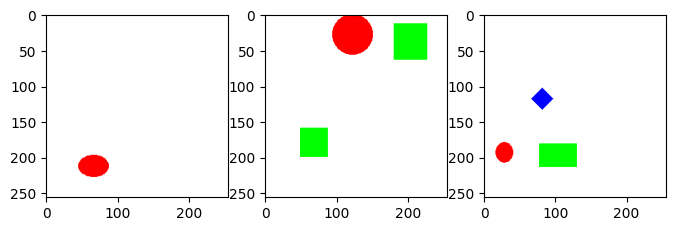

In [4]:
# Display some images

fig = plt.figure(figsize=(8,8))
rows=1
columns=3

for idx in range(1, columns * rows +1):
    fig.add_subplot(rows, columns, idx)
    plt.imshow(train_img[idx])

In [5]:
# Preprocess data
train_img = tf.keras.applications.vgg16.preprocess_input(train_img)

# Build model
base_model = tf.keras.applications.VGG16(input_shape=[H,W,3], include_top=False, weights='imagenet')

x = base_model.output # 8x8x512

out_conf=tf.keras.layers.Conv2D(1,(1,1),padding='same',activation='sigmoid', name='out_conf')(x)
out_coord=tf.keras.layers.Conv2D(2,(1,1),padding='same',activation='sigmoid', name='out_coord')(x)
out_size=tf.keras.layers.Conv2D(2,(1,1),padding='same',activation='sigmoid', name='out_size')(x)
out_class=tf.keras.layers.Conv2D(3,(1,1),padding='same',activation='softmax', name='out_class')(x)

model=tf.keras.Model(inputs=base_model.input, outputs=[out_conf,out_coord,out_size,out_class])
model.summary()

I0000 00:00:1742788497.375187   55914 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6194 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:26:00.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 256, 256,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 128, 128,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 128, 128,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 128, 128,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 64, 64,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 64, 64,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 64, 64,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 64, 64,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 32, 32,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 32, 32,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 32, 32,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 32, 32,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 16, 16,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 16, 16,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 16, 16,    │  2,359,808 │ block5_conv1[0][

 Total params: 14,718,792 (56.15 MB)

 Trainable params: 14,718,792 (56.15 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Custom loss functions

def conf_loss_func(y_true,y_pred):
  obj_mask=tf.cast(y_true[:,:,:,0],tf.bool)
  noobj_mask=tf.logical_not(obj_mask)
  sqrerr = tf.square(y_true-y_pred)
  loss_obj_conf=tf.reduce_mean(tf.boolean_mask(sqrerr,obj_mask))
  loss_noobj_conf=tf.reduce_mean(tf.boolean_mask(sqrerr,noobj_mask))
  loss_conf = loss_obj_conf + loss_noobj_conf
  return loss_conf

def coord_loss_func(y_true,y_pred):
  obj_mask=tf.cast(y_true[:,:,:,0],tf.bool)
  y_true=y_true[:,:,:,1:3]
  loss_coord=tf.reduce_mean(tf.boolean_mask(tf.square(y_true-y_pred),obj_mask))
  return loss_coord

def size_loss_func(y_true,y_pred):
    obj_mask=tf.cast(y_true[:,:,:,0],tf.bool)
    y_true=y_true[:,:,:,1:3]
    loss_size=tf.reduce_mean(tf.boolean_mask(tf.square(y_true-y_pred),obj_mask))
    return loss_size

def class_loss_func(y_true,y_pred):
    obj_mask=tf.cast(y_true[:,:,:,0],tf.bool)
    y_true=y_true[:,:,:,1]
    loss_class=tf.reduce_mean(tf.boolean_mask(
    tf.keras.losses.sparse_categorical_crossentropy(y_true,y_pred),
    obj_mask))
    return loss_class

In [7]:
# Train and save model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
loss={'out_conf':conf_loss_func,'out_coord':coord_loss_func,'out_size':size_loss_func,'out_class':class_loss_func},
              loss_weights={'out_conf':3,'out_coord':4,'out_size':2,'out_class':1})
history = model.fit(x=train_img,
y={'out_conf':train_label_conf,'out_coord':tf.concat([train_label_conf, train_label_coord],-1),'out_size':tf.concat([train_label_conf, train_label_size],-1),
'out_class':tf.concat([train_label_conf, train_label_class],-1)},epochs=20,batch_size=20,validation_split=0.25)

model.save('model.keras')

2025-03-24 12:54:59.096698: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2359296000 exceeds 10% of free system memory.
2025-03-24 12:55:00.336492: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2359296000 exceeds 10% of free system memory.


Epoch 1/20


I0000 00:00:1742788503.519095   56008 service.cc:152] XLA service 0x3f877ff0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742788503.519121   56008 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2025-03-24 12:55:03.575525: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742788504.012409   56008 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-03-24 12:55:11.700528: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
I0000 00:00:1742788522.534107   56008 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most o

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 1.7224 - out_class_loss: 0.5838 - out_conf_loss: 0.0979 - out_coord_loss: 0.1479 - out_size_loss: 0.1266

2025-03-24 12:55:52.707614: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


150/150 ━━━━━━━━━━━━━━━━━━━━ 59s 254ms/step - loss: 1.7160 - out_class_loss: 0.5808 - out_conf_loss: 0.0976 - out_coord_loss: 0.1475 - out_size_loss: 0.1262 - val_loss: 0.1210 - val_out_class_loss: 0.0020 - val_out_conf_loss: 0.0231 - val_out_coord_loss: 0.0063 - val_out_size_loss: 0.0122
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 209ms/step - loss: 0.0999 - out_class_loss: 0.0013 - out_conf_loss: 0.0201 - out_coord_loss: 0.0051 - out_size_loss: 0.0090 - val_loss: 0.0770 - val_out_class_loss: 0.0013 - val_out_conf_loss: 0.0166 - val_out_coord_loss: 0.0038 - val_out_size_loss: 0.0055
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 32s 212ms/step - loss: 0.0647 - out_class_loss: 8.1875e-04 - out_conf_loss: 0.0139 - out_coord_loss: 0.0031 - out_size_loss: 0.0050 - val_loss: 0.0624 - val_out_class_loss: 8.9165e-04 - val_out_conf_loss: 0.0116 - val_out_coord_loss: 0.0045 - val_out_size_loss: 0.0043
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 33s 219ms/step - loss: 0.0500 - out_class_loss: 6.4241e-04 -

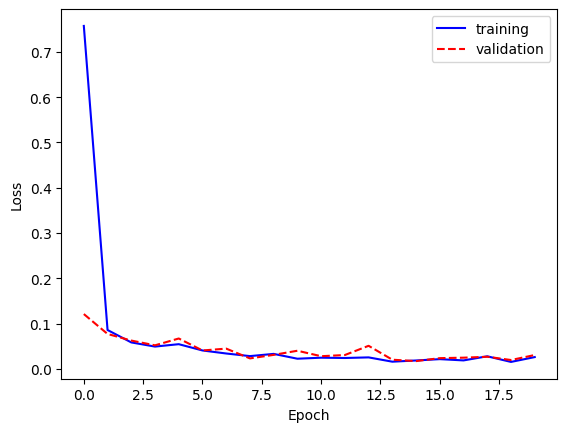

In [8]:
# Show training history
plt.figure()
plt.plot(history.history['loss'], 'b-', label='training')
plt.plot(history.history['val_loss'], 'r--', label='validation')
plt.xlabel('Epoch'), plt.ylabel('Loss'), plt.legend()
plt.show()

In [9]:
# Generate test images and labels
N=20
H,W=256,256
GHN,GWN=8,8
GH,GW=int(H/GHN),int(W/GWN)
Mmax=3 # maximum number of objects
test_img=np.zeros([N,H,W,3],dtype=np.uint8)
test_img.fill(255)
test_label_conf=np.zeros([N,GHN,GWN,1],dtype=np.float32)
test_label_coord=np.zeros([N,GHN,GWN,2],dtype=np.float32)
test_label_size=np.zeros([N,GHN,GWN,2],dtype=np.float32)
test_label_class=np.zeros([N,GHN,GWN,3],dtype=np.float32)

In [10]:
for n in range(N):
    M=random.randint(1,Mmax)
    for m in range(M):
        obj_class=random.randint(0,2) # 0: diamond, 1: rectangle, 2: ellipse
        bContinue=True
        while bContinue:
            x,y=random.randint(0,W-1),random.randint(0,H-1)
            bw,bh=random.randint(int(W/16),int(W/4)),random.randint(int(H/16),int(H/4))
            if(x-bw/2<0): x=x-(x-bw/2)
            elif(x+bw/2>W-1): x=x-(x+bw/2-(W-1))
            if(y-bh/2<0): y=y-(y-bh/2)
            elif(y+bh/2>H-1): y=y-(y+bh/2-(H-1))
            x=int(x); y=int(y)
            i,j=int(x/GW),int(y/GH)
            if np.sum(test_label_conf[n,np.max([0,j-2]):np.min([GHN,j+2]),np.max([0,i-2]):np.min([GWN,i+2])])==0: bContinue=False
        if obj_class==0: # diamond
            cv.fillPoly(test_img[n],[np.array([[x,y-int(bh/2)],[x-int(bw/2),y],
            [x,y+int(bh/2)],[x+int(bw/2),y]])],color=(0,0,255))
        elif obj_class==1: # rectangle
            cv.rectangle(test_img[n],(x-int(bw/2),y-int(bh/2)),(x+int(bw/2),y+int(bh/2)),
            color=(0,255,0),thickness=-1)
        else: # ellipse
            cv.ellipse(test_img[n],(x,y),(int(bw/2),int(bh/2)),0,0,360,
            color=(255,0,0),thickness=-1)
        test_label_conf[n,j,i]=1
        test_label_coord[n,j,i,0:2]=x,y
        test_label_size[n,j,i,0:2]=bw,bh
        test_label_class[n,j,i]=obj_class

In [12]:
# Preprocess test images
test_img_ = tf.keras.applications.vgg16.preprocess_input(test_img)
# Predict object locations in test images
model=tf.keras.models.load_model('model.keras',
custom_objects={'conf_loss_func':conf_loss_func,
'coord_loss_func':coord_loss_func,
'size_loss_func':size_loss_func,
'class_loss_func':class_loss_func})
pre_conf,pred_coord,pred_size,pred_class=model.predict(test_img_)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


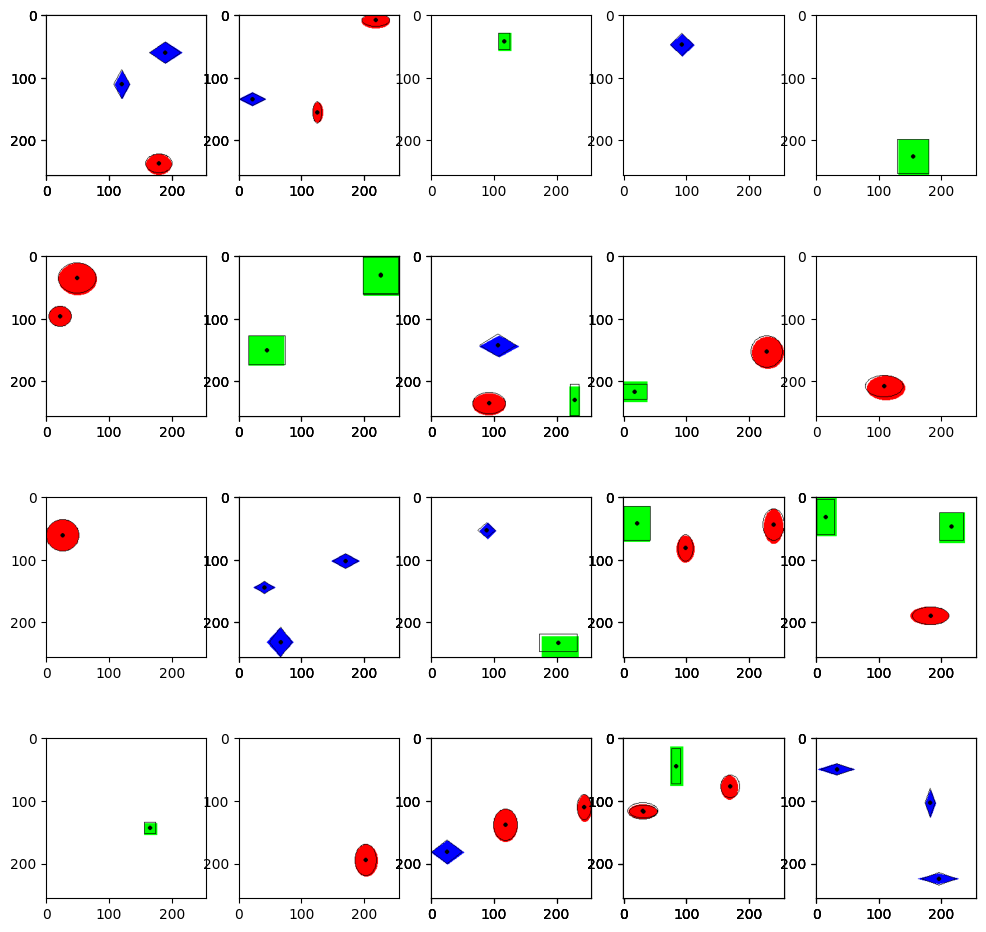

In [21]:
# Display prediction results

fig = plt.figure(figsize=(12, 12))
rows = 4
columns=5

for n in range(0, columns * rows):
    for i in range(GWN):
        for j in range(GHN):
            if pre_conf[n,j,i]>0.1:
                x=int(i*GW+(pred_coord[n,j,i,0]*GW))
                y=int(j*GH+(pred_coord[n,j,i,1]*GH))
                bw=int(pred_size[n,j,i,0]*(W/4))
                bh=int(pred_size[n,j,i,1]*(H/4))
                obj_class=np.argmax(pred_class[n,j,i,:],axis=-1)
                
                if obj_class==0: # diamond
                    cv.polylines(test_img[n],[np.array([[x,y-int(bh/2)],[x-int(bw/2),y],
                                                        [x,y+int(bh/2)],[x+int(bw/2),y]])], isClosed=True,color=(0,0,0))
                elif obj_class==1: # rectangle
                    cv.rectangle(test_img[n],(x-int(bw/2),y-int(bh/2)),(x+int(bw/2),y+int(bh/2)), color=(0,0,0),thickness=1)
                else: # ellipse
                    cv.ellipse(test_img[n],(x,y),(int(bw/2),int(bh/2)),0,0,360, color=(0,0,0),thickness=1)
                cv.circle(test_img[n],center=(x,y),radius=2,color=(0,0,0),thickness=2)
                fig.add_subplot(rows, columns, n+1)
                plt.imshow(test_img[n])